In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/avg_price_demand_OCT_NOV_2021.csv")
df = df.set_index("hour")

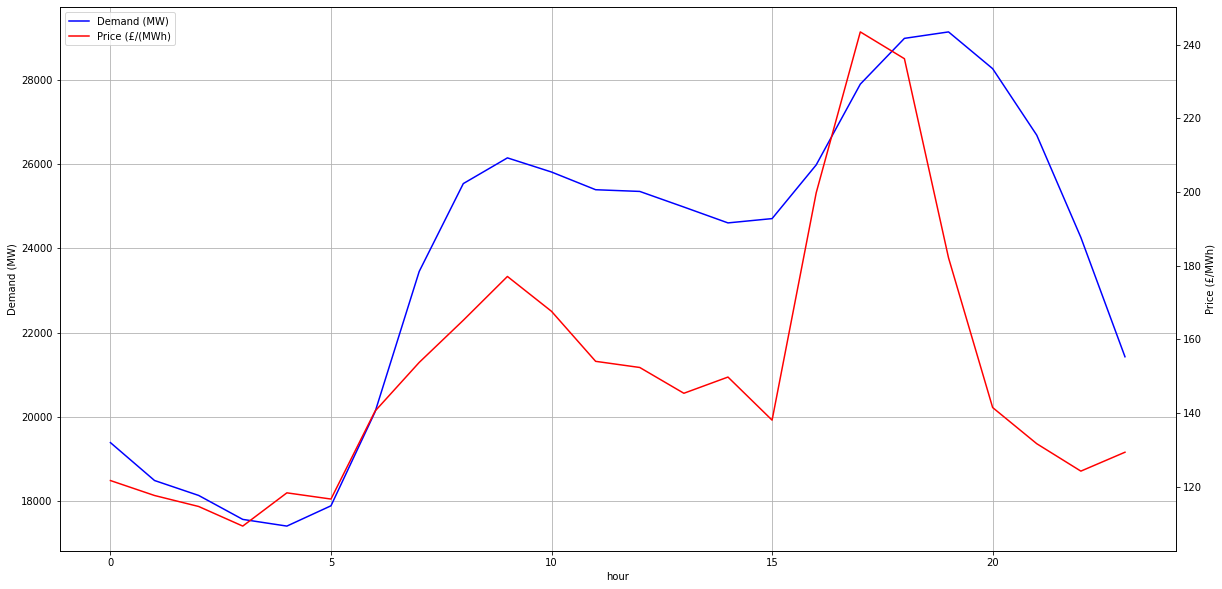

In [3]:

plt.figure(figsize=(20,10))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax1.set_ylabel("Demand (MW)")
ax1.set_xlabel("Hour")

ax2 = df["Price (pounds/MWh)"].plot(color='red', grid=True, secondary_y=True, label='Price (£/(MWh)')
ax2.set_ylabel("Price (£/MWh)")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Initial exploration

88224699.0305642

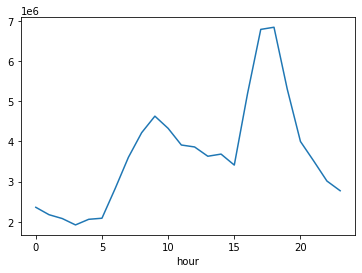

In [4]:

df["price"] = df["Price (pounds/MWh)"] * df["Demand (MW)"]
df["price"].plot()
df['price'].sum()

In [5]:
df["demand_grad"] = np.gradient(df["Demand (MW)"])


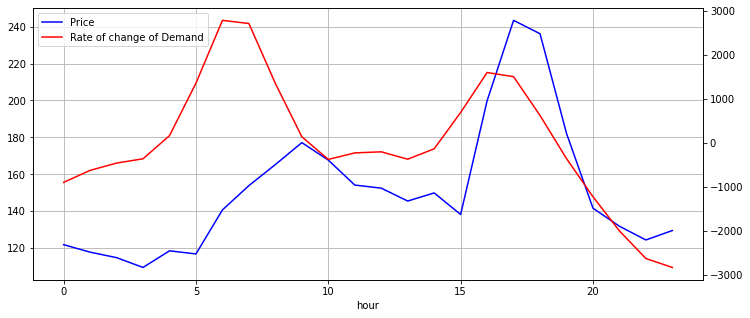

In [6]:

plt.figure(figsize=(12,5))
ax1 = df["Price (pounds/MWh)"].plot(color='blue', grid=True, label='Price')
ax2 = df["demand_grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Demand')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

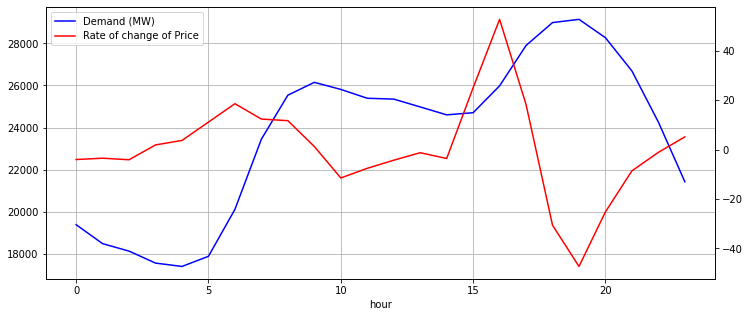

In [7]:
df["grad"] = np.gradient(df["Price (pounds/MWh)"])

plt.figure(figsize=(12,5))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Linear price prediction

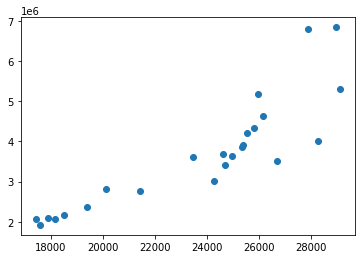

In [8]:
plt.scatter(df["Demand (MW)"], df["price"])

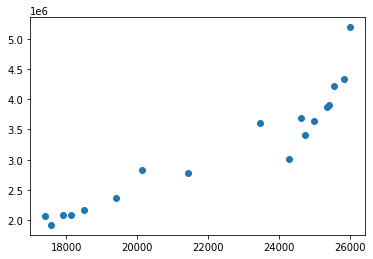

In [9]:
# filter off points which don't fit with the trend
dff = df[df["Demand (MW)"] <= 26000]
plt.scatter(dff["Demand (MW)"], dff["price"])

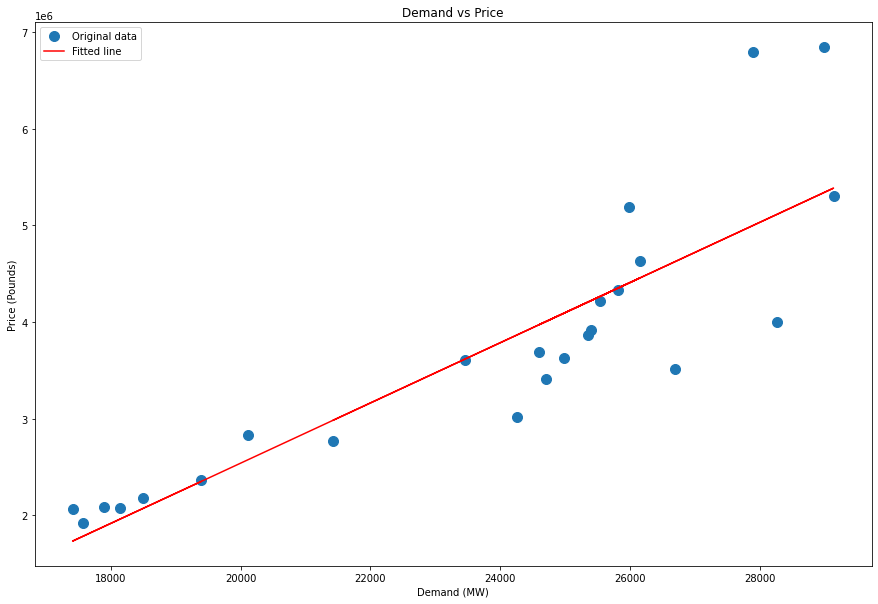

In [10]:
import numpy as np

order = 1

z = np.polyfit(df["Demand (MW)"], df["price"], order)

p = np.poly1d(z)

plt.figure(figsize=(15,10))
plt.plot(df["Demand (MW)"], df["price"], 'o', label='Original data', markersize=10)
plt.plot(df["Demand (MW)"], df["Demand (MW)"].apply(lambda x: p(x)), 'r', label='Fitted line')
plt.legend()
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Price (Pounds)")
ax.set_title("Demand vs Price")
plt.show()


price = lambda x: p(x)/ x # returns the price per MWh for a given demand

## 2d price prediction

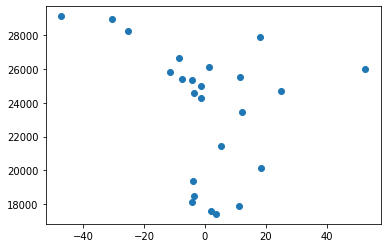

In [11]:
plt.scatter(df["grad"], df["Demand (MW)"])

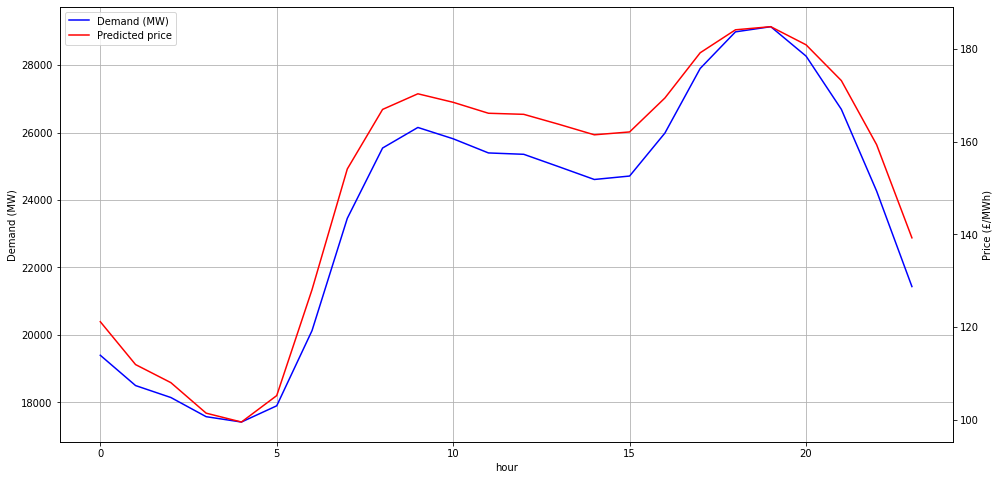

In [12]:
df["predicted_price"] = df["Demand (MW)"].apply(price)
plt.figure(figsize=(16,8))
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')

ax1.set_ylabel("Demand (MW)")
ax1.set_xlabel("Hour")

ax2 = df["predicted_price"].plot(color='red', grid=True, secondary_y=True, label='Predicted price')
ax2.set_ylabel("Price (£/MWh)")


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

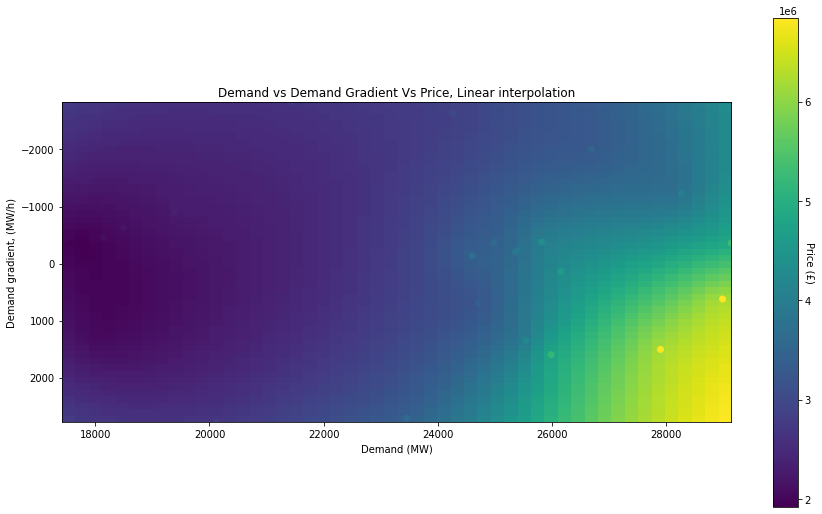

In [13]:
# from https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python

from scipy.interpolate import Rbf


def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def plot(x,y,z,grid):
    plt.figure(figsize=(15,9))
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.scatter(x,y,c=z)
    cbar = plt.colorbar()
    cbar.set_label("Price (£)", rotation=270)


# Setup: Generate data...
n = 10
nx, ny = 50, 50
x_price = df["Demand (MW)"]
y_price = df["demand_grad"]
z_price = df["price"]
xi = np.linspace(x_price.min(), x_price.max(), nx)
yi = np.linspace(y_price.min(), y_price.max(), ny)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Calculate scipy's RBF
grid2 = scipy_idw(x_price,y_price,z_price,xi,yi)
grid2 = grid2.reshape((ny, nx))

plot(x_price,y_price,z_price,grid2)
plt.title("Demand vs Demand Gradient Vs Price, Linear interpolation")
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Demand gradient, (MW/h)")

plt.show()

In [14]:
price_prediction_2d = lambda demand, grad: scipy_idw(x_price,y_price,z_price,demand, grad)/demand

print(price_prediction_2d(28000,0))

price_prediction_2d_df = lambda x: price_prediction_2d(x["Demand (MW)"], x["demand_grad"])

190.73548533402464


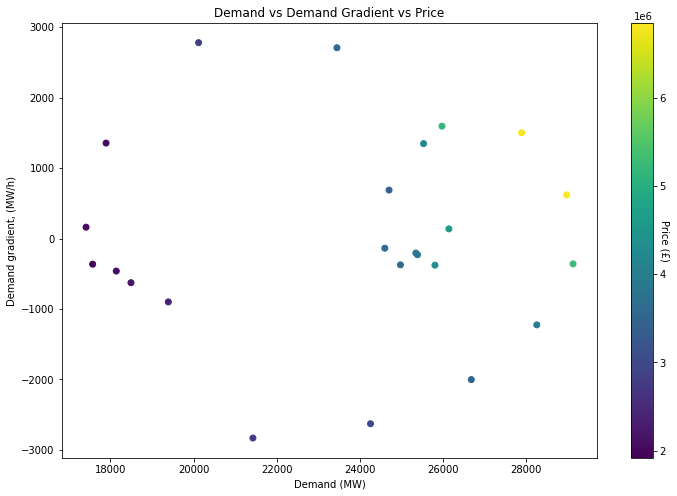

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(df["Demand (MW)"], df["demand_grad"], c=df["price"], cmap='viridis')
ax = plt.gca()
ax.set_xlabel("Demand (MW)")
ax.set_ylabel("Demand gradient, (MW/h)")
ax.set_title("Demand vs Demand Gradient vs Price")
cbar = plt.colorbar()
cbar.set_label("Price (£)", rotation=270)
plt.show()

## Gradient based 

In [16]:
dfc = df.copy()

def model1(dfc):

    amount = 500 # MW
    battery_size = 30 # GW

    for i in range(battery_size * int(1000/amount)):
        a = (dfc["demand_grad"] * 1.5) + dfc["Demand (MW)"]
        a.at[0] = a.mean()
        dfc.at[a.idxmax(), "Demand (MW)"] -= amount
        dfc.at[a.idxmin(), "Demand (MW)"] += amount
        dfc["demand_grad"] = np.gradient(dfc["Demand (MW)"])
    
    return dfc

dfc = model1(dfc)


## Simple Charge / Discharge based

In [17]:
dfc = df.copy()

def model2(dfc):
    amount = 500 # MW
    battery_size = 30 # GWh
    max_charge_rate = 2000 # MW/h
    max_discharge_rate = 6000 #MW/h

    dfc["charge"] = 0
    dfc["discharge"] = 0

    for i in range(battery_size * int(1000/amount)):
        # maxh = dfc["Demand (MW)"].idxmax()
        # dfc.at[maxh, "Demand (MW)"] -= amount

        looking = True
        highest_index = 1
        while looking:
            maxh = dfc["Demand (MW)"].nlargest(highest_index).index.values[-1]

            if dfc.at[maxh, "discharge"] >= max_discharge_rate:
                highest_index += 1
            else:
                dfc.at[maxh, "Demand (MW)"] -= amount
                looking = False
        
        dfc.at[maxh, "discharge"] += amount
        #dfc.at[maxh, "Demand (MW)"] -= amount


        looking = True
        lowest_index = 1
        while looking:
            minh = dfc["Demand (MW)"].nsmallest(lowest_index).index.values[-1]

            if dfc.at[minh, "charge"] >= max_charge_rate:
                lowest_index += 1
            else:
                dfc.at[minh, "Demand (MW)"] += amount
                looking = False
        
        dfc.at[minh, "charge"] += amount
        #dfc.at[minh, "Demand (MW)"] += amount

        return dfc
    
    dfc = model2(dfc)


## Price & discharge / charge based

In [50]:
dfc = df.copy()
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
normal_cost = a.sum()

dfc = df.copy()

def model3(dfc, battery_size=30, max_charge_rate=2000, stop_point=0):
    cost_save = []
    amount = 500 # MW
    # battery_size = 30 # GWh
    # max_charge_rate = 2000 # MW/h
    max_discharge_rate = 6000 #MW/h
    if stop_point==0:
        stop_point = battery_size * 1000/amount + 1

    dfc["charge"] = 0
    dfc["discharge"] = 0

    for i in range(battery_size * int(1000/amount)):

        if i == stop_point:
            break

        dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
        dfc["demand_grad"] = np.gradient(dfc["Demand (MW)"])

        # maxh = dfc["Demand (MW)"].idxmax()
        # dfc.at[maxh, "Demand (MW)"] -= amount

        looking = True
        highest_index = 1
        while looking:
            maxh = dfc["price_prediction_2d"].nlargest(highest_index).index.values[-1]

            if dfc.at[maxh, "discharge"] >= max_discharge_rate:
                highest_index += 1
            else:
                dfc.at[maxh, "Demand (MW)"] -= amount
                looking = False
        
        dfc.at[maxh, "discharge"] += amount
        #dfc.at[maxh, "Demand (MW)"] -= amount


        looking = True
        lowest_index = 1
        while lowest_index <= 22 and looking:
            minh = dfc["price_prediction_2d"].nsmallest(lowest_index).index.values[-1]

            if dfc.at[minh, "charge"] >= max_charge_rate:
                lowest_index += 1
            else:
                dfc.at[minh, "Demand (MW)"] += amount
                looking = False
        
        dfc.at[minh, "charge"] += amount
        #dfc.at[minh, "Demand (MW)"] += amount

        dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
        a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
        cost_save.append(a.sum())

    
    return dfc, cost_save

dfc = model3(dfc)

# model 3 format is different now
try:
    cost_save = dfc[1]
    dfc = dfc[0]
except:
    pass
    

## Simple model

In [19]:
dfc = df.copy()


def model4(dfc):
    amount = 500 # MW
    battery_size = 30 # GW

    dfc["charge"] = 0

    for i in range(battery_size * int(1000/amount)):
        dfc.at[dfc["Demand (MW)"].idxmax(), "Demand (MW)"] -= amount
        minh = dfc["Demand (MW)"].idxmin()
        
        dfc.at[minh, "Demand (MW)"] += amount
        dfc.at[minh, "charge"] += amount
    
    return dfc

dfc = model4(dfc)

## Plot Model result

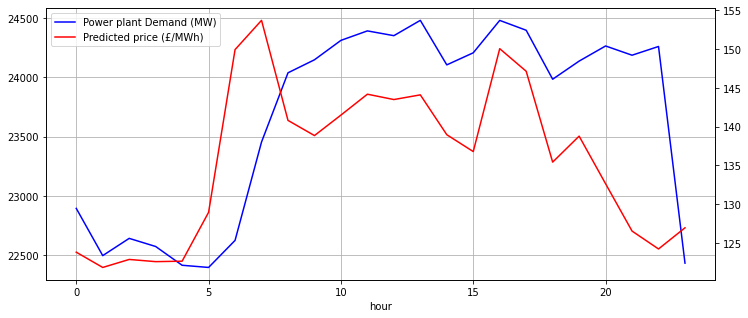

3256.966423307064


In [35]:
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)

plt.figure(figsize=(12,5))

ax1 = dfc["Demand (MW)"].plot(color='blue', grid=True, label='Power plant Demand (MW)')
ax2 = dfc["price_prediction_2d"].plot(color='red', grid=True, secondary_y=True, label='Predicted price (£/MWh)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

print(dfc["price_prediction_2d"].sum())

3413.3462537343526


<Figure size 864x360 with 0 Axes>

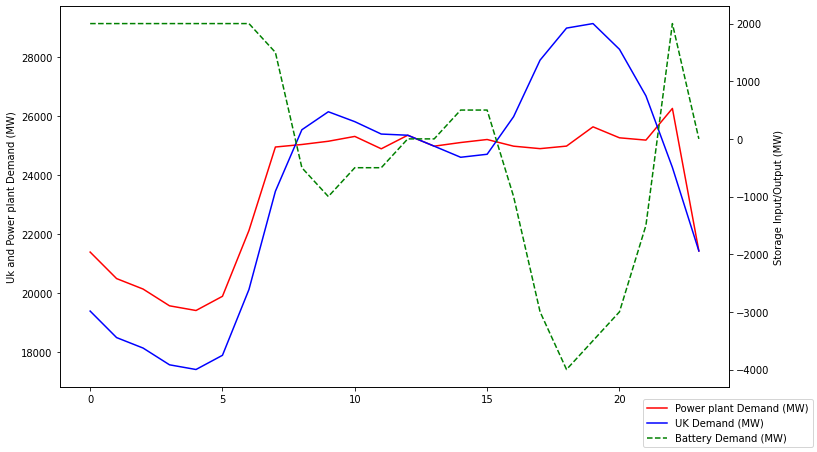

In [114]:
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)

plt.figure(figsize=(12,5))

battery_demand = dfc["charge"] - dfc["discharge"]
dfc["battery demand"] = battery_demand

fig = plt.figure(figsize=(12,7))
a1 = plt.plot(dfc.index, dfc["Demand (MW)"], color='red', label='Power plant Demand (MW)')
plt.ylabel("Uk and Power plant Demand (MW)")
a2 = plt.plot(df.index, df["Demand (MW)"], color='blue', label='UK Demand (MW)')
a3 = plt.gca().twinx().plot(dfc.index, dfc["battery demand"], "--", color='green', label='Battery Demand (MW)')
plt.ylabel("Storage Input/Output (MW)")
fig.legend(a1+a2+a3, ["Power plant Demand (MW)", "UK Demand (MW)", "Battery Demand (MW)"], loc=4)
plt.savefig("uk_demand_battery_demand.png", facecolor="w")
print(dfc["price_prediction_2d"].sum())

## compare against original

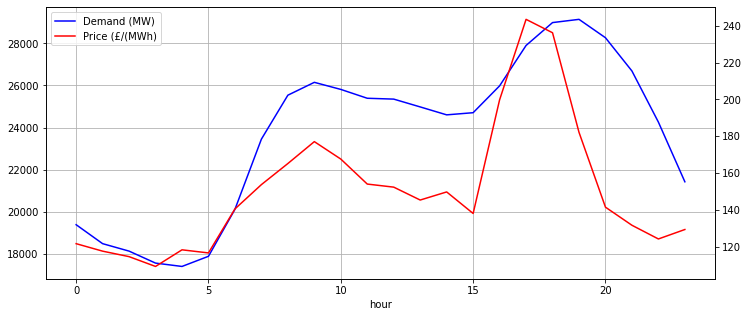

In [21]:
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["Price (pounds/MWh)"].plot(color='red', grid=True, secondary_y=True, label='Price (£/(MWh)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Run the different models

In [22]:
dfc = df.copy()
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())


dfc = df.copy()
dfc = model1(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model2(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model3(dfc)[0]
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

dfc = df.copy()
dfc = model4(dfc)
dfc["price_prediction_2d"] = dfc.apply(price_prediction_2d_df, axis=1)
a = dfc["price_prediction_2d"] * dfc["Demand (MW)"]
print(a.sum())

88224699.03056419
77960254.39196868
87994863.65366119
81451168.3636426
77144397.51942217


## Plot Charge / Discharge

KeyError: 'discharge'

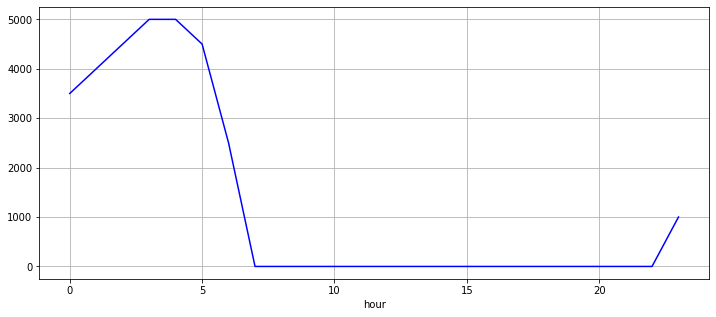

In [23]:
dfc["predicted_price"] = dfc["Demand (MW)"].apply(price)
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = dfc["charge"].plot(color='blue', grid=True, label='Charge (MW)')
ax2 = dfc["discharge"].plot(color='red', grid=True, secondary_y=True, label='Discharge (MW)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Work out price in / price out

In [ ]:
dfc = df.copy()
dfc, cost_save = model3(dfc, max_charge_rate=2500, stop_point=36)
price_in = sum([dfc["price_prediction_2d"][i] * demand for i, demand in enumerate(dfc['charge'])])/dfc["charge"].sum()
price_out = sum([dfc["price_prediction_2d"][i] * demand for i, demand in enumerate(dfc['discharge'])])/dfc["discharge"].sum()
print([price_in, price_out])

[119.48869476207297, 151.00874339700852]


In [ ]:
dfc = df.copy()
dfc, cost_save = model3(dfc, max_charge_rate=2500, stop_point=36)
price_in = sum([dfc["Price (pounds/MWh)"][i] * demand for i, demand in enumerate(dfc['charge'])])/dfc["charge"].sum()
price_out = sum([dfc["Price (pounds/MWh)"][i] * demand for i, demand in enumerate(dfc['discharge'])])/dfc["discharge"].sum()
print([price_in, price_out])

[119.93969626944445, 191.489573575]


## Initial look at cost saves between two charge rates

ValueError: x and y must have same first dimension, but have shapes (60,) and (36,)

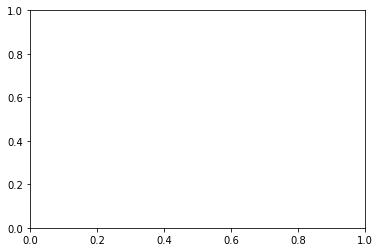

In [ ]:
plt.plot(np.array(range(60))/2, cost_save, color='blue', label="2 GW/h charge rate")
plt.plot(np.array(range(60))/2, cost_save2, color='red', label = "4 GW/h charge rate")
ax2 = plt.gca()

plt.xlabel("GWh of storage")
plt.ylabel("Total day cost")

#h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h2,l2, loc=2)
plt.title("Cost save depending on charge rate")
plt.show()


## Comparing lots of different charge rates

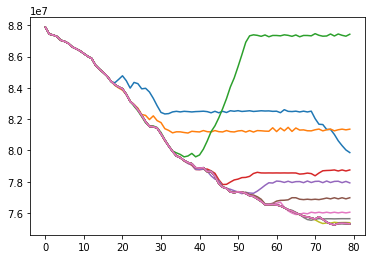

In [ ]:
charge_rate = []
diffs = []
cost_saves = []

for i in range(3,20):
    i = i * 1000 / 2
    dfc = df.copy()
    dfc, cost_save = model3(dfc, max_charge_rate=i)
    cost_save = pd.Series(cost_save)
    plt.plot(cost_save)
    diff = cost_save.diff().to_list()
    diffs.append(diff)
    cost_saves.append(cost_save)



7590177.605792567
16500


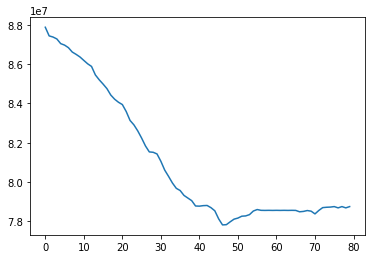

In [ ]:
# I tried to find an automatic way of detecting when more energy storage was useless but couldn't, i did it manually
no = 3
plt.plot(range(len(cost_saves[no])), cost_saves[no])
stop_point = 32
print(cost_saves[no][0] - cost_saves[no][stop_point])
print(500 * (stop_point+1))